# 物体セグメンテーションアルゴリズム"watershed"を詳しく
2017/2/22 posted at http://qiita.com/ysdyt/items/5972c9520acf6a094d90

## Watershed algorithm

- 接触する物体をうまい具体に分離（セグメンテーション）して認識してくれるアルゴリズム
- OpenCVでも利用可能
- 結構古典的なアルゴリズム
- watershed = 分水嶺？
    - 画像の輝度勾配を山と谷の地形図に見立て、そこに水を流すイメージをした時に、水を貯める分水嶺（壁）を"輪郭"として判定する手法  
    参考: [The Watershed Transformation](http://cmm.ensmp.fr/~beucher/wtshed.html)
    ![watershed](./watershed.gif)
    - 要は、**"オブジェクトの輪郭"**を正しく判定するアルゴリズム

## 実際に動かしてみる

以下、watershedの[公式チュートリアル](http://docs.opencv.org/3.1.0/d3/db4/tutorial_py_watershed.html)を追っていきつつ、補足内容を追加

### 環境確認

In [1]:
!python -V

import cv2 
cv2.__version__

Python 2.7.11 :: Anaconda custom (x86_64)


'3.1.0'

pythonは2.7, OpenCVは3.1で行った。  
OpenCVはインストールが一手間かかるかもだけど、ググるといろいろ出てくるのでがんばってください。  
pythonは3系でも、OpenCVは3以外でも実行できるはずなので、そのへんはよしなに。

### モジュールの読み込み

In [2]:
%matplotlib inline  
import cv2
import numpy as np
from matplotlib import pyplot as plt

### 画像の読み込み
画像はチュートリアルと同じものを使う（pixelサイズ=252×312, RGB画像）

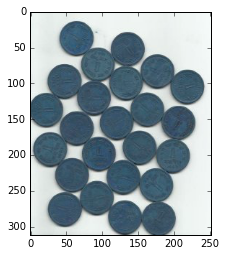

In [3]:
img = cv2.imread('./coins.jpg')
plt.imshow(img)

以上のような"相互に接触するオブジェクト"を対象にする。  
このコインが互いに別のオブジェクトとして以下のように認識されることが最終目標

![img](./result.jpg)

図の通り、それぞれのコインの輪郭が認識され青線で囲われている。

#### （補足）なぜ画像が青っぽいのか？
openCVにread imageすると、画像の色情報はRGBからBGRの並びに変換されることが原因（なぜこの並びなのかは不明）  
今回は青っぽくても何も問題ないが、元の色に戻して見たい場合は cv2.COLOR_BGR2RGB を使う

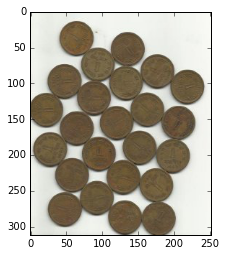

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Otsu法を使って画像の二値化処理

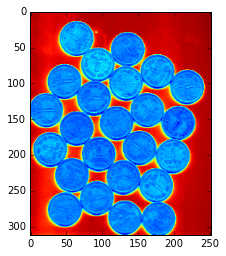

In [5]:
# まずはgray scaleへ変換する
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

グレースケールだから白黒じゃないの？という感じだが、これも以下のオプションを取ると白黒になる

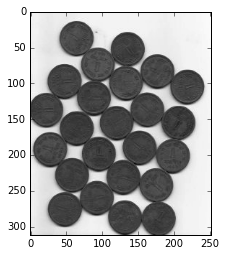

In [6]:
plt.imshow(gray,cmap='gray')

#### Otus法（大津法）とは

- ある画像を２値化（ピクセル値を255（最大値）or 0（最小値）にする、バイナリー化、ざっくり言うなら白黒化）にする場合、その閾値を決定する必要がある。  
    - Otus法（日本人考案！）は画像の輝度ヒストグラムを元に、いい感じの閾値を自動で決定してくれるアルゴリズム。  
    - ただし、ヒストグラムが大きく二つに別れるところをバッツリと二つに分ける（=閾値を決定する）アルゴリズムなので、そういった双峰性を持たないヒストグラムに対してはうまく閾値を決定できないらしい。  

閾値で分割？という人はこちらの画像を見るとわかりやすい  
参考: [大津の二値化処理（判別分析法）とは](http://opencv.blog.jp/algorithm/otsu_thresholding)

大津法の二値化によって決定した閾値: 162.0


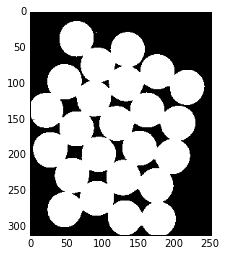

In [7]:
# Otsu法で画像を二値化する
thresh,bin_img = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(bin_img,cmap='gray')
print '大津法の二値化によって決定した閾値:',thresh

二値化できた！ こちらも同じく cmap='gray' を引数に取って白黒の二値化画像にしている（cmap='gray'しないと赤と青の画像になる）

### 画像に含まれる小さなノイズ（white noise）を削除する
先の画像をよくよく見てみると、画像中に極小さな白点が見られる。  
そういったノイズ（white noise）を消すための処理が以下

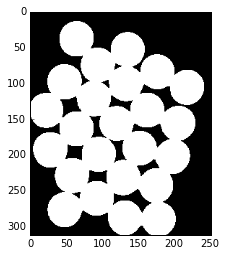

In [8]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(bin_img,cv2.MORPH_OPEN,kernel,iterations = 2)
plt.imshow(opening,cmap='gray')

一つ前の画像とよくよく見比べてみると、ほきほど存在したノイズが消えていることがわかる

ここで実行した cv2.morphologyEx について補足説明  
morphologyExによって、"モルフォロジー演算"なるものを行っている

#### [モルフォロジー演算](http://opencv.jp/sample/morphology.html)
    - 与えられた2値画像または濃淡画像からの特徴抽出を目的とした図形変形手法の理論体系
    - 画像のノイズ除去，平滑化，形状記述，テクスチャ解析，細線化処理などに用いられる．
        - Dilation, Erosion, Opening, Closingの基本演算と、
        - モルフォロジーグラジエント（Dailationした画像からErosionした画像を減算することで，エッジを検出する）
        - トップハット変換（元画像からOpeningした画像を減算する）
        - ブラックハット変換（Closingした画像から元画像を減算する）
        の７種類
        
    - 要は、以下の画像のように、対象画像を太くしたり補足したり、それらを組み合わせたりして目的のオブジェクトを取り出す方法（画像は上記リンクより拝借）    
![morphology](./morphology.png)
こちらのページもわかりやすい: [モルフォロジー変換](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)


- モルフォロジー演算の"opening"処理は、ノイズの除去のために利用されている  
    - "opening"処理で行っていることは、画像をErosion（侵食）してからDilation（膨張）しているだけ。  
    - どうしてそれでノイズ処理していることになるの？って人は以下のリンクの画像を見比べれば理解しやすい  
        参考: [膨張・収縮・オープニング・クロージング](http://imagingsolution.blog107.fc2.com/blog-entry-101.html)

### 明確な背景（sure background）の抽出

ここからは、watershedアルゴリズムが実際に"輪郭"のデータを抽出するために必要となる"ヒント"となる情報を取り出す処理になる。  
"ヒント"として必要になるデータは以下の4つ。  
1. 明確な背景（sure background）情報
2. 明確な前景(sure foreground)情報
3. 背景でも前景でもないunknownな領域の情報
4. 1~3の情報に"ラベル"をつける

まずは 「1. 明確な背景（sure background）情報」を取得する

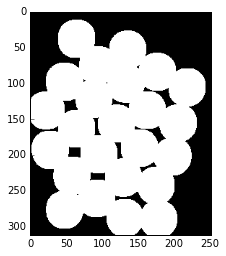

In [9]:
# モルフォロジー演算のDilationを使う
sure_bg = cv2.dilate(opening,kernel,iterations=2)
plt.imshow(sure_bg,cmap='gray')

図を見ると分かる通り、先程のモルフォロジー演算でオブジェクトをDilation（膨張）させている。  
オブジェクト領域を少し余分に取ることで、黒の部分は「確実に背景」の情報になる。

### 距離変換を行う（オブジェクトと背景の距離を出す）

「1.明確な背景（sure background）情報」が取得できたので、次は「2.明確な前景(sure foreground)情報」を取得する。  
そのためにまず、全景（=オブジェクト =foreground）と背景(=background)の距離を出す。

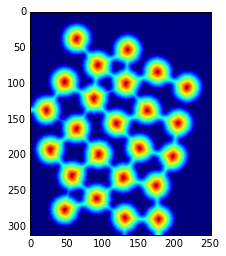

In [10]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.imshow(dist_transform)

図のように、背景に近いほど青く（=距離変換後の値が小さい）、オブジェクトの中心ほど赤く（=距離変換後の値が大きい）なる"距離"情報を得た。

### 距離変換の結果から、確実な前景（sure foreground）の抽出

閾値（距離変換で得られた値の最大値×0.5）: 11.984498024


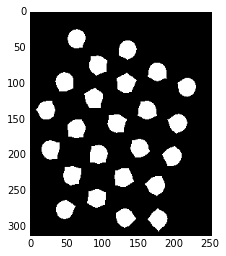

In [11]:
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
print '閾値（距離変換で得られた値の最大値×0.5）:',ret
plt.imshow(sure_fg,cmap='gray')

距離変換した画像に対して今度は任意の閾値を指定して（大津法は使わないで）また2値化を行う。  
閾値は「距離変換で得られた値の最大値×0.5」にしている。

これで、「一回り小さめのオブジェクトの除法（=背景からの距離が遠いオブジェクトの情報 =オブジェクトの中心点付近の情報）」、つまり、「絶対に前景」の情報が得られた。

### 背景でも前景でもないunknowな部分（境界）を抽出する
「3. 背景でも前景でもないunknownな領域の情報」を取得する。  
これは意外に簡単な処理で抽出できる。

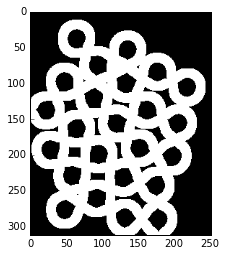

In [12]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,cmap='gray')

`subtract(sure_bg,sure_fg)` 、つまり「絶対に背景」から「絶対に前景」の情報を引いているだけ。  

### 領域をラベルする
watershedが輪郭を認識するために必要な最後の"ヒント"である、「4. 1~3の情報に"ラベル"をつける」を作成する。  

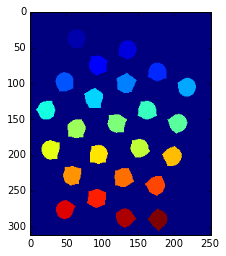

In [13]:
# foregroundの1オブジェクトごとにラベル（番号）を振っていく
ret, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers)

「絶対に前景」のデータに対して connectedComponents を適応し、各オブジェクトにラベル（番号）を振っていく。  
（上図で各オブジェクとの色が違うのは、それぞれにラベルとして異なる値が振られているから）

numpyのuniqueを使って、存在するラベルとその存在個数をカウントしてみる

In [14]:
# markersのデータの中をのぞいみている
np.unique(markers,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24], dtype=int32),
 array([65956,   518,   505,   536,   524,   538,   542,   513,   545,
          510,   534,   513,   529,   536,   526,   539,   539,   528,
          542,   546,   523,   533,   511,   513,   525]))

出力結果の通り、markerのデータ内容は
    - 0~24のラベル
    - それらの各存在ピクセル数
となっている。
    
そしてそれぞれのラベルは、    
    - background -> 0
    - foreground -> 1~24のint （全部で24個のコイン）
と割り振られている

後々の処理の都合上、markerデータの全ての値に1を足し、backgroundが1, foregroundが2から始まるようにする

In [15]:
markers = markers+1
np.unique(markers,return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([65956,   518,   505,   536,   524,   538,   542,   513,   545,
          510,   534,   513,   529,   536,   526,   539,   539,   528,
          542,   546,   523,   533,   511,   513,   525]))

markerのデータ内容は以下のように更新された状態
    - background -> 1
    - foreground -> 2~25のint （全部で24個のコイン）

次に、unknowの領域を0に指定する

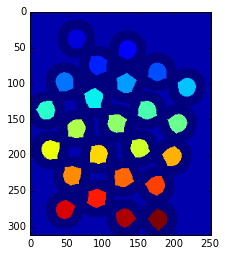

In [16]:
markers[unknown==255] = 0
plt.imshow(markers)

unknownの領域が濃い青色になっている

In [17]:
np.unique(markers,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([37037, 28919,   518,   505,   536,   524,   538,   542,   513,
          545,   510,   534,   513,   529,   536,   526,   539,   539,
          528,   542,   546,   523,   533,   511,   513,   525]))

この段階でのmarkerのデータ内容は以下

    - unknown -> 0
    - background -> 1
    - foreground -> 2~25のint
    
これでようやく全ての"ヒント"情報が集まったので、watershedにつっこむ。

### markerデータを元にwatershedを実行

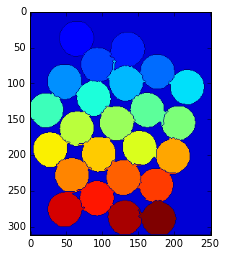

In [18]:
# "ヒント"であるmarkersをwatershedに適応する
markers = cv2.watershed(img,markers)
plt.imshow(markers)

各コインが認識できた！

watershed実行後のmarkersには境界のデータが追加されているので確認してみる。

In [19]:
np.unique(markers,return_counts=True)

(array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32),
 array([ 3995, 33238,  1752,  1762,  1624,  1698,  1736,  1805,  1738,
         1711,  1710,  1764,  1623,  1748,  1709,  1738,  1715,  1717,
         1710,  1743,  1794,  1688,  1715,  1755,  1683,  1753]))

更新されたmarkerのデータ内容
    - 境界領域 -> -1
    - background -> 1
    - foreground -> 2~25のint

最後に、確認として得られた境界領域だけ赤で塗ってみる

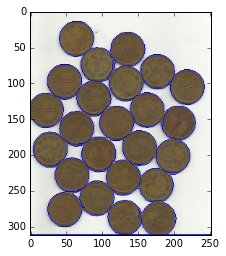

In [20]:
# 境界の領域を赤で塗る
img[markers == -1] = [255,0,0]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

出来た！

ただし、よく見てみると分かる通り（そして公式にも書かれているとおり）、一部の輪郭はひしゃげていて完全にうまく分離できているわけではない。  
そうはいいつつ大部分はうまく輪郭抽出できているので、これからのさらなる精度向上はまぁ各自頑張って！って感じなんでしょうか。

## 主な参考ページ

- [Image Segmentation with Watershed Algorithm - OpenCV](http://docs.opencv.org/3.1.0/d3/db4/tutorial_py_watershed.html)
- [The Watershed Transformation - IMAGE SEGMENTATION AND MATHEMATICAL MORPHOLOGY](http://cmm.ensmp.fr/~beucher/wtshed.html)